# PDC project - Channel Model

In [1]:
import states
import bitarray
import numpy as np
import matplotlib.pyplot as plt

## Serialization

In [2]:
"""Convert UTF-8 string to bits

@param: (s) Given string
@return: numpy.ndarray of bits living in [-1, 1]
"""
def string_to_bits(s):
    bs = bitarray.bitarray()
    bs.frombytes(s.encode('utf-8'))
    bs = np.array(list(bs))
    return np.where(bs == 0, -1, bs)

In [3]:
"""Convert bits to UTF-8 string

@param: (bs) numpy.ndarray of bits living in [-1, 1]
@return: String corresponding to the input bits
"""
def bits_to_string(bs):
    return bitarray.bitarray(list(np.where(bs == -1, 0, bs))).tobytes().decode('utf-8')

## Convolutional Encoding

In [4]:
"""Find optimal symbol duplication factor

@param: (bs) Bit sequence living in [-1, 1]
@param: (blocklen) Block length allocation
@return: Optimal symbol duplication factor
"""
def optimal_repeat(bs, blocklen, mod=3):
    optimal = blocklen // len(bs)
    return optimal - (optimal % 3)

### Convolutional Encoder

In [5]:
"""Convolutional Encoder

@param: (bs) Bit sequence living in [-1, 1]
@return: Convolutionally encoded bit array
"""
def convolutional_encoder(bs):
    bs = np.append([1, 1], bs)
    bs = np.append(bs, [1,1])
    codewords = []
    
    for i in range(2, len(bs)):
        codewords.append(bs[i]*bs[i-2])
        codewords.append(bs[i]*bs[i-1]*bs[i-2])
        
    return np.array(codewords)

In [6]:
"""Main Encoder Module

@param: (bs) Bit sequence living in [-1, 1]
@param: (repeat) Symbol duplication factor
@param: (blocklen) Block length allocation
@return: Encoded bit string ready to send
"""
def encoder(bs, repeat=None, blocklen=60000):
    if repeat is not None and repeat % 3 != 0 and repeat != 1:
        raise Exception('Repeat arg. has to be a multiple of 3 or 1.')
    codewords = convolutional_encoder(bs)
    repeat = optimal_repeat(codewords, blocklen) if repeat is None else repeat
    return np.repeat(codewords, repeat), repeat

### Erasure Detection

In [7]:
"""Detect index of erasure

@param: (yss) List of bit sequences
@return: Erased index modulo 3
"""
def detect_erasure(yss, mod=3):
    bins = np.sum(np.abs(yss), axis=1)
    mods = []
    for i in range(mod):
        mods.append(np.sum(bins[i::3]))
    return np.argmin(mods)

In [8]:
"""Remove erased index symbols

@param: (ys) Noised bit sequence from channel output
@return: List of bit sequences without erased symbols
"""
def remove_erasures(ys, repeat):
    dec_ys = [ys[i::repeat] for i in range(repeat)]
    mod = detect_erasure(dec_ys)
    return [dec_ys[i] for i in range(repeat) if i % 3 != mod]

### Convolutional Decoder

In [9]:
"""Convert Viterbi state to decimal index

@param: (alpha) Viterbi state
@return: Corresponding index
"""
def to_dec(alpha):
    return int(str(alpha[0]) + str(alpha[1]), 2)

In [10]:
"""Convolutional Decoder - Viterbi algorithm

@param: (ys) Noised bit sequence from channel output
@param: (transitions) Viterbi states transitions 
@return: Decoded bit sequence living in [-1, 1]
"""
def convolutional_decoder(ys, transitions):
    
    # maximum depth
    maxj = (len(ys) // 2) + 1
    
    # create empty data structures
    alphas = [set() for _ in range(maxj)]
    paths = [[list() for _ in range(4)] for _ in range(maxj)]
    paths_cost = [[-np.inf for _ in range(4)] for _ in range(maxj)]
    
    # initializing the structures
    paths_cost[0][to_dec((1,1))] = 0 
    alphas[0] = {(1,1)}
    
    for j in range(1, maxj):        
        for alpha in alphas[j-1]:
            for beta in [(0, alpha[0]), (1, alpha[0])]:
                
                x = transitions[alpha][beta]['cw']
                
                edge_cost = x[0]*ys[2*j-1-1] + x[1]*ys[2*j-1]
                subpath_cost = paths_cost[j-1][to_dec(alpha)]
                cost = edge_cost + subpath_cost
                
                alphas[j].add(beta)
                
                if cost > paths_cost[j][to_dec(beta)]:
                    paths_cost[j][to_dec(beta)] = cost
                    paths[j][to_dec(beta)] = paths[j-1][to_dec(alpha)] + [transitions[alpha][beta]['bit']]
                
    return paths[maxj-1][to_dec((1,1))][:-2]

In [11]:
"""Main Decoder Module

@param: (ys) Noised bit sequence
@param: (repeat) Symbol duplication factor
@return: Decoded bit sequence living in [-1, 1] 
"""
def decoder(ys, repeat):
    if repeat % 3 != 0 and repeat != 1:
        raise Exception('Repeat arg. has to be a multiple of 3 or 1.')
    
    yss = remove_erasures(ys, repeat)
    ys = np.sum(yss, axis=0)
    transitions = states.transitions()

    return convolutional_decoder(ys, transitions)

## Server Pipeline

In [12]:
"""Encode text from file

The encoded bit sequence is saved
in a new file with extended name.

@param: (filename) File name
@return: Symbol duplication factor used
@return: Block length used for communication
"""
def encode(filename):
    file = open(filename, 'r')
    data = file.read()
    file.close()
    
    bs = string_to_bits(data)
    xs, repeat = encoder(bs)
    
    np.savetxt(filename[:-4] + '-encoded.txt', xs)
    
    return repeat, len(xs)

In [13]:
"""Decode noisy bit sequence from file

The decoded string of characters is
saved in a new file with extended name.

@param: (filename) File name
@param: (repeat) Symbol duplication factor
@return: Decoded string of characters
"""
def decode(filename, repeat):
    ys = np.loadtxt(filename)
    bs = decoder(ys, repeat)
    data = bits_to_string(np.array(bs))
    
    file = open(filename[:-4] + '-decoded.txt', 'w')
    file.write(data)
    file.close()
    
    return data

---
# Main Program

1. Encode given  `files/input.txt` file
2. Send to channel through EPFL server
3. Decode given `files/output.txt` file

In [14]:
repeat, blocklen = encode('files/input.txt')

In [15]:
print(f'We are using {blocklen} symbols during transmission.')

We are using 56316 symbols during transmission.


In [16]:
! python3 client/client.py --input_file 'files/input-encoded.txt' --output_file 'files/output.txt' --srv_hostname iscsrv72.epfl.ch --srv_port 80

In [17]:
decode('files/output.txt', repeat)

"Ceci est un test. Je m'appelle Antoine et j'écris des accents pour faire des tests.\n😀\n"

---
# Test section

## Channel Models

In [18]:
def silent_channel(chanInput):
    chanInput = np.clip(chanInput,-1,1)
    erasedIndex = np.random.randint(3)
    chanInput[erasedIndex:len(chanInput):3] = 0
    return chanInput, erasedIndex

In [19]:
def noisy_channel(chanInput, var = 10):
    chanInput = np.clip(chanInput,-1,1)
    erasedIndex = np.random.randint(3)
    chanInput[erasedIndex:len(chanInput):3] = 0
    return chanInput + np.sqrt(var)*np.random.randn(len(chanInput)), erasedIndex

## Serialization

In [20]:
def serialization_test(filename):
    data = open('files/input.txt', 'r').read()
    res = bits_to_string(string_to_bits(data))
    return data == res

In [21]:
serialization_test('files/input.txt')

True

## Erasure detection

In [22]:
erasure_string = open('files/input.txt', 'r').read()
erasure_bits = string_to_bits(erasure_string)

In [23]:
def erasure_test(inp, channel, repeats = 30, iters = 100):
    errors = {}
    logs = {}
    bits = inp
    
    for rep in range(3, repeats, 3):
        xs = np.repeat(bits, rep)

        loc_err = 0
        loc_logs = {}

        for i in range(iters):
            xsi, ei = channel(xs)
            dec_xsi = [xsi[i::rep] for i in range(rep)]
            mod = detect_erasure(dec_xsi)
            if ei != mod:
                loc_err += 1
                loc_logs[i] = {
                    'xs': xsi,
                    'dec_xs': dec_xsi,
                    'ei': ei,
                    'mod': mod
                }

        errors[rep] = loc_err
        logs[rep] = loc_logs
    
    return errors, logs

### Over silent channel

In [24]:
errors, _ = erasure_test(erasure_bits, silent_channel, 15, 100)

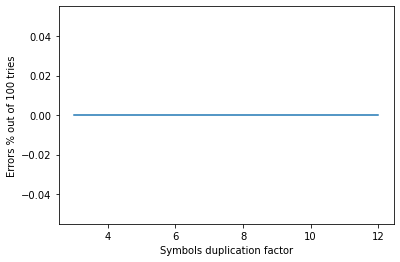

In [25]:
plt.plot(list(errors.keys()), list(errors.values()))
plt.xlabel('Symbols duplication factor')
plt.ylabel(f'Errors % out of {100} tries')
plt.show()

### Over noisy channel

In [26]:
repeats, iters = 60, 300
errors, logs = erasure_test(erasure_bits, noisy_channel, repeats, iters)

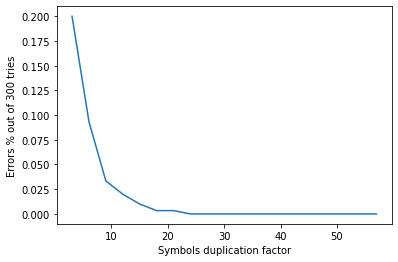

In [27]:
plt.plot(list(errors.keys()), np.array(list(errors.values()))/iters)
plt.xlabel('Symbols duplication factor')
plt.ylabel(f'Errors % out of {iters} tries')
plt.show()

## Viterbi algorithm

In [28]:
def viterbi_test(ys):
    return convolutional_decoder(ys, states.transitions())

In [29]:
ys_book = [1,3,-2,1,4,-1,5,5,-3,-3,1,-6,2,-4]
viterbi_test(ys_book)

[1, 1, 1, 1, -1]

## Convolutional Encoding

In [30]:
chars = "Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀"

In [31]:
def conv_enc_test(string, prints=False):
    bts = string_to_bits(string)
    enc, rep = encoder(bts)
    out = noisy_channel(enc, 10)[0]
    dec = decoder(out, rep)
    try:
        res =  bits_to_string(np.array(dec))
    except UnicodeDecodeError as err:
        res = 'Cant decode: UTF8 error.'
    if prints:
        print(f'Block usage: {len(enc)} ({len(enc) / 60000})')
    return res

In [32]:
conv_enc_test(chars, prints=True)

Block usage: 58500 (0.975)


"Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀"

### Statistics

In [33]:
iters = 1000

In [34]:
def conv_enc_stats(string, iters):
    accuracy = iters
    logs = {}
    for i in range(iters):
        print(i, end='\r')
        result = conv_enc_test(string)
        if result != string:
            accuracy -= 1
            logs[i] = result
    return accuracy/iters, logs

In [35]:
def print_stats(string, acc, iters):
    print(f'For string of length: {len(string)}')
    print(f'Correct decoding rate over {iters} tests: {acc}')
    print(f'Correct decoding rate over {2} trials: { 1 - (1-acc)**2 }')

### Numero uno

In [36]:
acc, logs = conv_enc_stats(chars, iters)

In [37]:
print_stats(chars, acc, iters)

For string of length: 76
Correct decoding rate over 1000 tests: 0.948
Correct decoding rate over 2 trials: 0.997296


### Numero due

In [38]:
chars = "La nécessité de certains groupes marginalisés @ 你好"

In [39]:
acc, logs = conv_enc_stats(chars, iters)

In [40]:
print_stats(chars, acc, iters)

For string of length: 50
Correct decoding rate over 1000 tests: 1.0
Correct decoding rate over 2 trials: 1.0
